In [1]:
import typing
from typing import Any, Union, Optional, List, Dict

import math
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch import Tensor

In [2]:
class Model:
    # degree: int
    # weights: Tensor
    # regulations: Tensor
    # exponents: Tensor
    # regulation_factor: float

    # total_losshistory: np.ndarray

    def __init__(self, degree: int, regulation_factor: float = 0.0): #regulations: Union[Tensor, List[float], None] = None):
        if (degree < 0):
            raise ValueError(f"degree must be a non-negative integer")
        self.degree = degree
        self.weights = torch.rand(
            (degree+1,), dtype=torch.float, requires_grad=True)
        self.exponents = torch.linspace(0, degree, degree+1, dtype=torch.int)
        self.total_losshistory = np.array([])
        self.regulation_factor = regulation_factor
        # self.set_regulations(regulations)


    # def set_regulations(self, regulations: Union[Tensor, List[float], None] = None):
    #     self.regulations = regulations
    #     if type(regulations) == list:
    #         self.regulations = torch.tensor(regulations, dtype=torch.float)
    #     elif regulations is None:
    #         self.regulations = torch.zeros((self.degree+1,), dtype=torch.float)
    #     if (self.regulations.size() != (self.degree+1,)):
    #         raise ValueError(f"regulations must be of size {self.degree+1}")

    def fit(self, x: Tensor, y: Tensor, epochs: int = 2000, learning_rate: float = 1e-4, regulation_factor: Optional[float] = None):
        if (regulation_factor is None): regulation_factor = self.regulation_factor
        input = self.extract_features(x)
        losshistory = np.array([])

        for t in range(epochs):
            y_pred = self.forward(input)
            loss = (y_pred - y).pow(2).sum() / len(y) + self.weights.abs().sum() * regulation_factor
            if (t % 10 == 0):
                losshistory = np.append(losshistory, loss.detach().numpy())
            loss.backward()
            with torch.no_grad():
                self.weights -= learning_rate * self.weights.grad
                self.weights.grad = None

        self.total_losshistory = np.append(self.total_losshistory, losshistory)
        return losshistory

    def __call__(self, x: Union[float, Tensor, np.ndarray]) -> Union[float, Tensor, np.ndarray]:
        y_pred = self.forward(self.extract_features(x)).detach()
        if (type(x) in [float, int]):
            return y_pred.item()
        if (type(x) == Tensor):
            return y_pred
        else:
            return y_pred.numpy()

    def extract_features(self, x: Tensor) -> Tensor:
      return x.unsqueeze(-1).pow(self.exponents)

    def forward(self, input: Tensor) -> Tensor:
      return input @ self.weights

    def printFunction(self):
        return " + ".join([f"{self.weights[i]:.2f} x^{i}" for i in range(self.degree, 0, -1)] + [f"{self.weights[0]:.2f}"])


In [3]:
m: Model = Model(3, regulation_factor=1)

In [4]:
x = torch.linspace(-math.pi, math.pi, 2000, dtype=torch.float)
y = torch.sin(x)

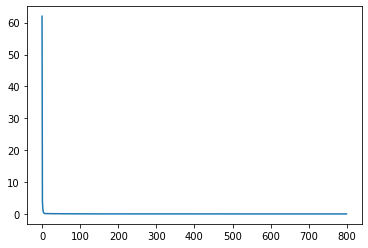

In [5]:
plt.plot(m.fit(x,y, learning_rate=1e-3, epochs=8000, regulation_factor=0))

-0.09 x^3 + -0.00 x^2 + 0.86 x^1 + 0.00


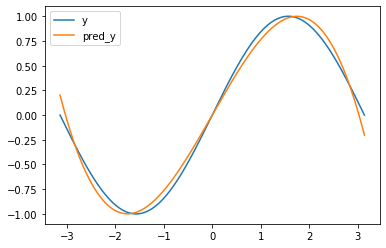

In [6]:
print(m.printFunction())

plt.plot(x, y, label="y")
plt.plot(x, m(x), label="pred_y")
plt.legend()